In [2]:
import pandas as pd
import json

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import PercentFormatter

import math

In [13]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
  'font.size': 8,
  'text.usetex': True,
  'text.latex.preamble': r'\usepackage{amsmath}',
  'pgf.texsystem': "pdflatex",
  'pgf.preamble': r'\usepackage{amsfonts}',
  #"font.family": "serif",
  #"pgf.rcfonts": False,
})

In [3]:
fig_width=6
fig_height=1.5

In [4]:
color_i = 0
colors = {}
def get_color(fun):
    global color_i
    global colors
    
    key = fun.lower()
    if key not in colors:
        options = list(mcolors.TABLEAU_COLORS) + list(mcolors.BASE_COLORS)[0:-1]
        colors[key] = options[color_i % len(options)]
        color_i += 1
    return colors[key]

def reset_colors():
    global color_i
    global colors
    color_i = 0
    colors = {}

In [5]:
results_file = f"../results.json"
with open (results_file) as file:
    data = json.load(file)
    df = pd.json_normalize(data, "benchmarks")

In [6]:
def dataset_name(d):
    return {
        'books': "amazon", 
        'fb': "facebook", 
        'gap_10': "gapped 10%", 
        'normal': "normal", 
        'osm': "open street map", 
        'seq': "sequential", 
        'uniform': "uniform", 
        'wiki': "wikipedia"
    }[d]
    
def get_dataset_order(d):
    return {ds: i for i, ds in enumerate([
        'seq',
        'gap_10',
        'normal',
        'uniform',
        'books',
        'wiki',
        'fb',
        'osm',
    ])}[d]

def human_func_name(f):
    return {
        'MultFibonacci64': "Fibonacci",
        'murmur_finalizer64': "Murmur3",
        
        'cht_64_16': "CHT ($\epsilon =16$)",
        'pgm_hash_eps4_epsrec4': "PGM ($\epsilon = 4$)",
        'radix_spline_err4_rbits18': "RS ($\epsilon = 4, r = 18$)",
        'rmi_hash_1000000': "RMI ($\leq 10^6$)",
        'trie_spline_err4': "PLEX ($\epsilon = 4$)"
    }[f]

def get_marker(f):
    if f.startswith("cht"):
        return "."
    if f.startswith("pgm"):
        return "1"
    if f.startswith("radix_spline"):
        return "v"
    if f.startswith("trie_spline"):
        return "^"
    if f.startswith("rmi"):
        return "x"
    
    return "*"

def map_probe_dist(d):
    return {'0': "uniform", '1': "exponential"}[d]

In [7]:
label = "label"
func_name = "fn_name"
dataset = "dataset"
dataset_size = "dataset_size"
dataset_order = "dataset_order"
overallocation = "overallocation"

winner_elems = "winner_elems"
normalized_winner_elems = "normalized_winner_elems"
empty_slots = "empty_buckets"
normalized_empty_slots = "normalized_empty_slots"
slot_count = "slot_count"
colliding_elems = "colliding_elems"

hashtable_bytes = "hashtable_bytes"
hashtable_bytes_per_key = "hashtable_bytes_per_key"
total_bytes = "total_bytes"
hashtable_lookup = "cpu_time"
probing_distribution = "probing_distribution"

def buckets_with(cnt):
    assert(cnt >= 1)
    return f"n_buckets_{cnt-1}"

slots_df = df[df["name"].str.startswith("BM_items_per_slot")].copy(deep=True)
slots_df[func_name] = slots_df[label].apply(lambda x : x.split(":")[0])
slots_df[dataset] = slots_df[label].apply(lambda x : x.split(":")[1])
slots_df[dataset_order] = slots_df[dataset].apply(get_dataset_order)
slots_df[normalized_winner_elems] = slots_df.apply(lambda x: x[winner_elems] / x[dataset_size], axis=1)
slots_df[slot_count] = slots_df.apply(lambda x: x[dataset_size] * x[overallocation], axis=1)
slots_df[normalized_empty_slots] = slots_df.apply(lambda x: x[empty_slots] / x[slot_count], axis=1)
slots_df[[func_name, dataset, dataset_size, overallocation, normalized_winner_elems, winner_elems, empty_slots, normalized_empty_slots, buckets_with(1), buckets_with(2), colliding_elems]]

chained_df = df[df["name"].str.startswith("BM_hashtable") & df["name"].str.contains("Chained")].copy(deep=True)
chained_df[func_name] = chained_df["label"].apply(lambda x: x[0:x.find("_do_")].removeprefix("chained_"))
chained_df[dataset] = chained_df["label"].apply(lambda x : x.split(":")[1])
chained_df[dataset_order] = chained_df[dataset].apply(get_dataset_order)
chained_df[probing_distribution] = chained_df["name"].apply(lambda x: map_probe_dist(x.split('/')[-2]))
chained_df[hashtable_bytes_per_key] = chained_df.apply(lambda x: x[hashtable_bytes] / x[dataset_size], axis=1)
chained_df[[func_name, dataset, dataset_size, overallocation, probing_distribution, hashtable_bytes_per_key, hashtable_lookup]]

,fn_name,dataset,dataset_size,overallocation,probing_distribution,hashtable_bytes_per_key,cpu_time
24,rmi_hash_1000000,seq,200000000.0,1.0,uniform,24.000002,221.450398
25,rmi_hash_1000000,gap_10,200000000.0,1.0,uniform,27.568542,246.806901
26,rmi_hash_1000000,uniform,199999975.0,1.0,uniform,35.340601,369.562838
27,rmi_hash_1000000,normal,199459933.0,1.0,uniform,35.338738,324.234475
28,rmi_hash_1000000,books,200000000.0,1.0,uniform,35.944308,390.351978
...,...,...,...,...,...,...,...
499,murmur_finalizer64,normal,199459933.0,2.0,exponential,55.359534,218.675499
500,murmur_finalizer64,books,200000000.0,2.0,exponential,55.356615,218.720546
501,murmur_finalizer64,fb,200000000.0,2.0,exponential,55.356607,219.455929
502,murmur_finalizer64,osm,200000000.0,2.0,exponential,55.359230,218.374822


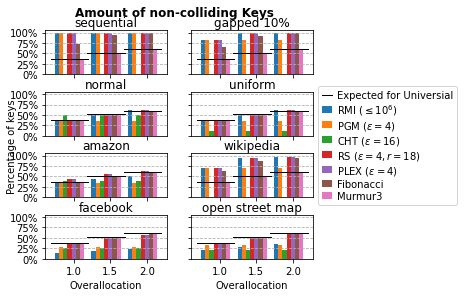

In [8]:
def plot_winners(data):
    rows = 4
    cols = 2
    
    fig, axs = plt.subplots(rows, cols, figsize=(fig_width*0.8, fig_height*rows*0.7), sharex=True, sharey=True)
    
    data = data.sort_values(by=[dataset_order, dataset_size, overallocation])
    for i, (ds, df) in enumerate(data.groupby([dataset], sort=False)):
        ax = axs[int(i / cols)][i % cols]
        ax.set_title(dataset_name(ds), pad=4)
        
        overallocs = list(set(df[overallocation]))
        overallocs.sort()
        func_cnt = len(set(df[func_name]))
        bar_width = 0.8 / func_cnt
        for j, (name, df) in enumerate(df.groupby([func_name], sort=False)):            
            for k, (overalloc, df) in enumerate(df.groupby([overallocation], sort=False)):
                ax.bar(
                    data=df, 
                    x=k - (func_cnt/2 * bar_width) + (j * bar_width) - bar_width / 2, 
                    height=normalized_winner_elems, 
                    width=bar_width, 
                    label=human_func_name(name) 
                    if k == 0 else None, 
                    color=get_color(name)
                )
                
        # draw optima
        for k, overalloc in enumerate([1.0, 1.5, 2.0]):
            optimum_y = math.e**(-1/overalloc) # from theory section
            min_x = k - (2 + func_cnt/2) * bar_width
            max_x = k + func_cnt/2 * bar_width
            # print(min_x, max_x)
            ax.plot([min_x, max_x], [optimum_y, optimum_y], label="Expected for Universial" if k == 0 else None, linestyle="-", linewidth=1, color="black")
        
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(overallocs)
        ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
        ax.grid(linestyle="--", axis="y", which="major")
        if int(i/cols) == rows-1:
            ax.set_xlabel("Overallocation")
            
    h, l = axs[0][0].get_legend_handles_labels()
    fig.legend(
        h, l,
        loc="center left",
        bbox_to_anchor=(0.9, 0.5),
        ncol=1,
        borderpad=0.4, 
        labelspacing=0.2, 
        handlelength=1.0, 
        handletextpad=0.5, 
        columnspacing=0.7
    )
    
    fig.suptitle(f"Amount of non-colliding Keys", y=0.96, fontweight="bold")
    fig.text(0.015, 0.5, 'Percentage of keys', va='center', rotation='vertical')
    
    fig.subplots_adjust(hspace=0.4)
    fig.savefig("winners.pdf", bbox_inches="tight", dpi=300)
    fig.savefig("winners.pgf", bbox_inches="tight", dpi=300)
            
plot_winners(slots_df)

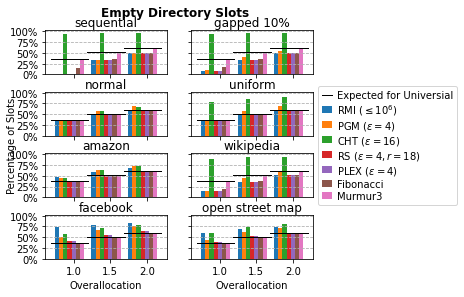

In [9]:
def plot_empty_slots(data):
    rows = 4
    cols = 2
    
    fig, axs = plt.subplots(rows, cols, figsize=(fig_width*0.8, fig_height*rows*0.7), sharex=True, sharey=True)
    
    data = data.sort_values(by=[dataset_order, dataset_size, overallocation])
    for i, (ds, df) in enumerate(data.groupby([dataset], sort=False)):
        ax = axs[int(i / cols)][i % cols]
        ax.set_title(dataset_name(ds), pad=4)
        
        overallocs = list(set(df[overallocation]))
        overallocs.sort()
        func_cnt = len(set(df[func_name]))
        bar_width = 0.8 / func_cnt
        for j, (name, df) in enumerate(df.groupby([func_name], sort=False)):            
            for k, (overalloc, df) in enumerate(df.groupby([overallocation], sort=False)):
                ax.bar(
                    data=df, 
                    x=k - (func_cnt/2 * bar_width) + (j * bar_width) - bar_width / 2, 
                    height=normalized_empty_slots, 
                    width=bar_width, 
                    label=human_func_name(name) 
                    if k == 0 else None, 
                    color=get_color(name)
                )
                
        # draw optima
        for k, overalloc in enumerate([1.0, 1.5, 2.0]):
            optimum_y = math.e**(-1/overalloc) # from theory section
            min_x = k - (2 + func_cnt/2) * bar_width
            max_x = k + func_cnt/2 * bar_width
            # print(min_x, max_x)
            ax.plot([min_x, max_x], [optimum_y, optimum_y], label="Expected for Universial" if k == 0 else None, linestyle="-", linewidth=1, color="black")
        
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(overallocs)
        ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
        ax.grid(linestyle="--", axis="y", which="major")
        if int(i/cols) == rows-1:
            ax.set_xlabel("Overallocation")
            
    h, l = axs[0][0].get_legend_handles_labels()
    fig.legend(
        h, l,
        loc="center left",
        bbox_to_anchor=(0.9, 0.5),
        ncol=1,
        borderpad=0.4, 
        labelspacing=0.2, 
        handlelength=1.0, 
        handletextpad=0.5, 
        columnspacing=0.7
    )
    
    fig.suptitle(f"Empty Directory Slots", y=0.96, fontweight="bold")
    fig.text(0.015, 0.5, 'Percentage of Slots', va='center', rotation='vertical')
    
    fig.subplots_adjust(hspace=0.4)
    fig.savefig("empty_slots.pdf", bbox_inches="tight", dpi=300)
    fig.savefig("empty_slots.pgf", bbox_inches="tight", dpi=300)
            
plot_empty_slots(slots_df)

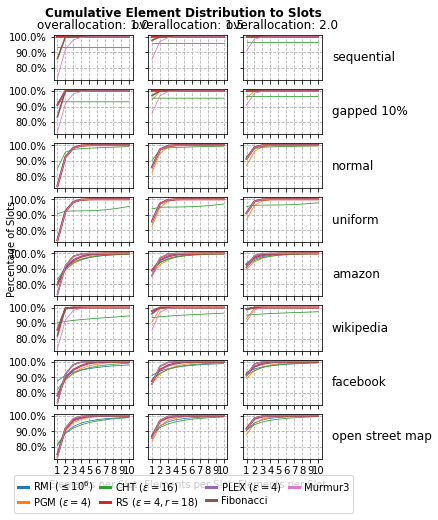

In [10]:
def plot_overfull_slots(data):
    rows = len(set(data[dataset]))
    cols = len(set(data[overallocation]))
    
    fig, axs = plt.subplots(rows, cols, figsize=(fig_width*0.8, fig_height*rows*0.65), sharex=True, sharey=True)
    
    x = range(1, 11)
    data = data.sort_values(by=[dataset_order, dataset_size, overallocation])
    for i, (ds, df) in enumerate(data.groupby([dataset], sort=False)):
        pad = 7.5
        axs[i][-1].annotate(
            dataset_name(ds), 
            xy=(0, 0.5),
            xytext=(85 + axs[i][-1].yaxis.labelpad + pad, 0),
            xycoords=axs[i][-1].yaxis.label, 
            textcoords='offset points',
            size='large', 
            ha='left', 
            va='center',
            rotation=0
        )

        for j, (overalloc, df) in enumerate(df.groupby([overallocation], sort=False)):
            ax = axs[i][j]                        
            if i == 0:
                ax.set_title(f"overallocation: {overalloc}")

            for k, (name, df) in enumerate(df.groupby([func_name], sort=False)):
                normalized_slots = [df[normalized_empty_slots] + sum([df[buckets_with(i)] for i in range(1, v+1)]) / df[slot_count] for v in x]
                ax.plot(
                    x, 
                    normalized_slots, 
                    label=human_func_name(name), 
                    linestyle="-", 
                    linewidth=1.6 if name.startswith("MultFibonacci") 
                            else 2.0 if name.startswith("radix_spline") else 0.8, 
                    color=get_color(name)
                )
            
            # ax.set_ylim(-0.02, 0.2)
            ax.set_yticks([0.8, 0.9, 1.0])
            ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
            ax.set_xticks(x)
            ax.grid(linestyle="--", axis="both", which="major")

            if i == rows-1:
                ax.set_xlabel("Elements per Slot")
            
    h, l = axs[0][0].get_legend_handles_labels()
    legend = fig.legend(
        h, l,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.02),
        ncol=4,
        borderpad=0.4, 
        labelspacing=0.2, 
        handlelength=1.0, 
        handletextpad=0.5, 
        columnspacing=0.7
    )
    for line in legend.get_lines():
        line.set_linewidth(3.0)
    
    fig.suptitle(f"Cumulative Element Distribution to Slots", y=0.93, fontweight="bold")
    fig.text(-0.01, 0.5, 'Percentage of Slots', va='center', rotation='vertical')
    
    fig.savefig("overfull_slots.pdf", bbox_inches="tight", dpi=300)
    fig.savefig("overfull_slots.pgf", bbox_inches="tight", dpi=300)

plot_overfull_slots(slots_df)

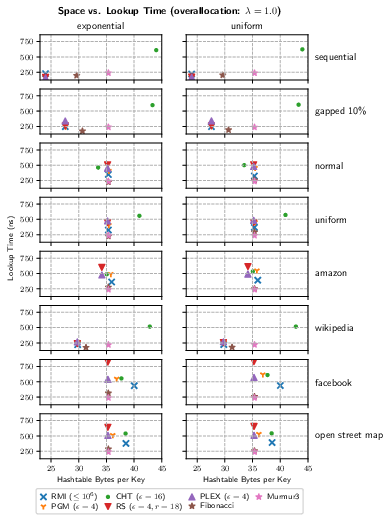

In [16]:
def plot_chained_pareto(data, overalloc):
    rows = len(set(data[dataset]))
    cols = len(set(data[probing_distribution]))
    
    fig, axs = plt.subplots(rows, cols, figsize=(fig_width*0.8, fig_height*rows*0.65), sharex=True, sharey=True)
    
    data = data[data[overallocation] == overalloc].sort_values(by=[dataset_order, dataset_size, probing_distribution]).copy(deep=True)
    for i, (ds, df) in enumerate(data.groupby([dataset], sort=False)):
        pad = 7.5
        axs[i][-1].annotate(
            dataset_name(ds), 
            xy=(0, 0.5),
            xytext=(125 + axs[i][-1].yaxis.labelpad + pad, 0),
            xycoords=axs[i][-1].yaxis.label, 
            textcoords='offset points',
            size='large', 
            ha='left', 
            va='center',
            rotation=0
        )

        for j, (probing_dist, df) in enumerate(df.groupby([probing_distribution], sort=False)):
            ax = axs[i][j]                        
            if i == 0:
                ax.set_title(probing_dist)

            for k, (name, df) in enumerate(df.groupby([func_name], sort=False)):
                ax.scatter(x=df[hashtable_bytes_per_key], y=df[hashtable_lookup], label=human_func_name(name), color=get_color(name), marker=get_marker(name))#, s=20 if name == "rmi_hash_100" else 14)

            ax.grid(linestyle="--", axis="both", which="major")

            if i == rows-1:
                ax.set_xlabel("Hashtable Bytes per Key")
            
    h, l = axs[0][0].get_legend_handles_labels()
    legend = fig.legend(
        h, l,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.02),
        ncol=4,
        borderpad=0.4, 
        labelspacing=0.2, 
        handlelength=1.0, 
        handletextpad=0.5, 
        columnspacing=0.7
    )
    for line in legend.get_lines():
        line.set_linewidth(3.0)
    
    fig.suptitle(f"Space vs. Lookup Time (overallocation: $\lambda = {overalloc}$)", y=0.93, fontweight="bold")
    fig.text(0.03, 0.5, 'Lookup Time (ns)', va='center', rotation='vertical')
    
    fig.savefig(f"chained_pareto_{overalloc}.pdf", bbox_inches="tight", dpi=300)
    fig.savefig(f"chained_pareto_{overalloc}.pgf", bbox_inches="tight", dpi=300)

plot_chained_pareto(chained_df, overalloc=1.0)